In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tqdm

In [ ]:
base_path = '/content/drive/MyDrive/Deepvoice_Detection_Dataset'

In [ ]:
!ls /content/drive/MyDrive/Deepvoice_Detection_Dataset/ASVspoof2019_LA_cm_protocols/
!ls /content/drive/MyDrive/Deepvoice_Detection_Dataset/flac | head

ASVspoof2019.LA.cm.dev.trl.txt	 ASVspoof2019.LA.cm.train.trn.txt
ASVspoof2019.LA.cm.eval.trl.txt
LA_T_1000137.flac
LA_T_1000406.flac
LA_T_1000648.flac
LA_T_1000824.flac
LA_T_1001074.flac
LA_T_1001114.flac
LA_T_1001169.flac
LA_T_1001718.flac
LA_T_1001871.flac
LA_T_1002656.flac


In [ ]:
# 필요한 라이브러리 정리

import pandas as pd
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import torchaudio
import random

from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 0. 데이터 분석 및 처리
# 1. Train 데이터셋과 Eval 데이터셋 합치기

# 2. 합친 데이터셋에서 8:2 비율로 나누기

# 3. 8은 학습에 사용하고 2는 평가에 사용하기 (train, test)

# 프로토콜 경로
train_protocol_path = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.train.trn.txt')
eval_protocol_path = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.eval.trl.txt')

# 프로토콜 불러오기
columns = ['speaker_id', 'file_id', 'system_id', 'attack_type', 'label']
df_train = pd.read_csv(train_protocol_path, sep='\s+', header=None, names=columns)
df_eval = pd.read_csv(eval_protocol_path, sep='\s+', header=None, names=columns)

# 병합
df_all = pd.concat([df_train, df_eval], ignore_index=True)

# stratified 8:2 분할
train_set, test_set = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all['label'],
    random_state=42
)

# 결과 저장
train_output = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'custom_protocol_train.txt')
test_output = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'custom_protocol_test.txt')

train_set.to_csv(train_output, sep=' ', header=False, index=False)
test_set.to_csv(test_output, sep=' ', header=False, index=False)


In [ ]:
# Step 1. custom_protocol_train.txt 불러오기

# 사용자 정의 protocol 불러오기
train_df = pd.read_csv(train_output, sep='\s+', header=None, names=['speaker_id', 'file_id', 'system_id', 'attack_type', 'label'])

# 라벨 숫자로 변환
train_df['label_binary'] = train_df['label'].map({'bonafide': 0, 'spoof': 1})

# 경로 설정 (train + eval 모두 대상이므로 두 경로 설정)
flac_dirs = [
    '/content/drive/MyDrive/Deepvoice_Detection_Dataset/flac',
    '/content/drive/MyDrive/Deepvoice_Detection_Dataset/ASVspoof2019_LA_eval/flac'
]

def find_flac_path(file_id):
    for base in flac_dirs:
        full_path = os.path.join(base, file_id + '.flac')
        if os.path.exists(full_path):
            return full_path
    return None

train_df['file_path'] = train_df['file_id'].apply(find_flac_path)
train_df = train_df[train_df['file_path'].notnull()]


In [ ]:
# Step 2. 데이터 전처리
# > 데이터 증강
# > bonafide만 증강해서 mel 변환, spoof는 그대로 mel 변환

def augment_waveform(path):
    waveform, sr = torchaudio.load(path)

    if random.random() < 0.5:
        speed = random.choice([0.9, 1.1])
        new_sr = int(sr * speed)
        waveform = torchaudio.functional.resample(waveform, sr, new_sr)
        waveform = torchaudio.functional.resample(waveform, new_sr, sr)

    if random.random() < 0.5:
        noise = 0.005 * torch.randn_like(waveform)
        waveform += noise

    return waveform

def extract_mel_from_waveform(waveform, sr=16000, n_mels=80, fixed_length=400):
    mel = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels)(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
    mel_np = mel_db.squeeze(0).numpy()

    # Padding or Trimming
    if mel_np.shape[1] < fixed_length:
        pad_width = fixed_length - mel_np.shape[1]
        mel_np = np.pad(mel_np, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_np = mel_np[:, :fixed_length]

    # ✅ z-score 정규화
    mel_np = (mel_np - mel_np.mean()) / (mel_np.std() + 1e-6)

    return mel_np


In [ ]:
# Step 3. 데이터 전처리
# > Mel-spectrogram 변환 및 저장

mel_list, label_list = [], []
batch_size = 2000
batch_idx = 0
save_dir = '/content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug'
os.makedirs(save_dir, exist_ok=True)

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="🔄 train mel 생성"):
    try:
        path = row['file_path']
        label = row['label_binary']

        if label == 0:  # bonafide → 증강
            waveform = augment_waveform(path)
        else:
            waveform, _ = torchaudio.load(path)

        mel = extract_mel_from_waveform(waveform)
        mel_list.append(mel)
        label_list.append(label)

    except Exception as e:
        print(f"⚠️ {path}: {e}")
        continue

    if len(mel_list) >= batch_size:
      data_path = os.path.join(save_dir, f'train_data_batch_{batch_idx}.npy')
      label_path = os.path.join(save_dir, f'train_labels_batch_{batch_idx}.npy')

      np.save(data_path, np.stack(mel_list))
      np.save(label_path, np.array(label_list))

      print(f"✅ 저장 완료: batch {batch_idx} → {data_path} ({len(mel_list)}개 샘플)")

      mel_list, label_list = [], []
      batch_idx += 1


# 마지막 저장
if mel_list:
    data_path = os.path.join(save_dir, f'train_data_batch_{batch_idx}.npy')
    label_path = os.path.join(save_dir, f'train_labels_batch_{batch_idx}.npy')

    np.save(data_path, np.stack(mel_list))
    np.save(label_path, np.array(label_list))

    print(f"✅ 마지막 저장 완료: batch {batch_idx} → {data_path} ({len(mel_list)}개 샘플)")



🔄 train mel 생성:   3%|▎         | 2011/77293 [00:34<4:22:26,  4.78it/s]

✅ 저장 완료: batch 0 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_0.npy (2000개 샘플)


🔄 train mel 생성:   5%|▌         | 4003/77293 [01:14<5:50:40,  3.48it/s]

✅ 저장 완료: batch 1 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_1.npy (2000개 샘플)


🔄 train mel 생성:   8%|▊         | 6011/77293 [01:57<4:00:07,  4.95it/s]

✅ 저장 완료: batch 2 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_2.npy (2000개 샘플)


🔄 train mel 생성:  10%|█         | 8008/77293 [02:37<3:39:56,  5.25it/s]

✅ 저장 완료: batch 3 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_3.npy (2000개 샘플)


🔄 train mel 생성:  13%|█▎        | 10009/77293 [03:17<3:32:21,  5.28it/s]

✅ 저장 완료: batch 4 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_4.npy (2000개 샘플)


🔄 train mel 생성:  16%|█▌        | 12008/77293 [03:59<3:34:50,  5.06it/s]

✅ 저장 완료: batch 5 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_5.npy (2000개 샘플)


🔄 train mel 생성:  18%|█▊        | 14000/77293 [09:53<43:19:12,  2.46s/it]

✅ 저장 완료: batch 6 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_6.npy (2000개 샘플)


🔄 train mel 생성:  21%|██        | 16000/77293 [18:35<42:24:23,  2.49s/it]

✅ 저장 완료: batch 7 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_7.npy (2000개 샘플)


🔄 train mel 생성:  23%|██▎       | 18000/77293 [27:07<41:08:45,  2.50s/it]

✅ 저장 완료: batch 8 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_8.npy (2000개 샘플)


🔄 train mel 생성:  26%|██▌       | 20000/77293 [35:42<40:00:14,  2.51s/it]

✅ 저장 완료: batch 9 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_9.npy (2000개 샘플)


🔄 train mel 생성:  28%|██▊       | 22000/77293 [44:21<37:26:55,  2.44s/it]

✅ 저장 완료: batch 10 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_10.npy (2000개 샘플)


🔄 train mel 생성:  31%|███       | 24000/77293 [53:05<36:11:55,  2.45s/it]

✅ 저장 완료: batch 11 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_11.npy (2000개 샘플)


🔄 train mel 생성:  34%|███▎      | 26001/77293 [1:02:20<25:21:04,  1.78s/it]

✅ 저장 완료: batch 12 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_12.npy (2000개 샘플)


🔄 train mel 생성:  36%|███▌      | 28000/77293 [1:11:03<33:54:22,  2.48s/it]

✅ 저장 완료: batch 13 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_13.npy (2000개 샘플)


🔄 train mel 생성:  39%|███▉      | 30000/77293 [1:19:44<32:55:23,  2.51s/it]

✅ 저장 완료: batch 14 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_14.npy (2000개 샘플)


🔄 train mel 생성:  41%|████▏     | 32000/77293 [1:28:17<31:52:34,  2.53s/it]

✅ 저장 완료: batch 15 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_15.npy (2000개 샘플)


🔄 train mel 생성:  44%|████▍     | 34000/77293 [1:36:50<29:41:26,  2.47s/it]

✅ 저장 완료: batch 16 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_16.npy (2000개 샘플)


🔄 train mel 생성:  47%|████▋     | 36000/77293 [1:45:28<28:43:14,  2.50s/it]

✅ 저장 완료: batch 17 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_17.npy (2000개 샘플)


🔄 train mel 생성:  49%|████▉     | 38000/77293 [1:54:11<27:01:13,  2.48s/it]

✅ 저장 완료: batch 18 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_18.npy (2000개 샘플)


🔄 train mel 생성:  52%|█████▏    | 40000/77293 [2:02:52<25:40:32,  2.48s/it]

✅ 저장 완료: batch 19 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_19.npy (2000개 샘플)


🔄 train mel 생성:  54%|█████▍    | 42000/77293 [2:11:24<30:32:02,  3.11s/it]

✅ 저장 완료: batch 20 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_20.npy (2000개 샘플)


🔄 train mel 생성:  57%|█████▋    | 44000/77293 [2:20:00<22:23:56,  2.42s/it]

✅ 저장 완료: batch 21 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_21.npy (2000개 샘플)


🔄 train mel 생성:  60%|█████▉    | 46000/77293 [2:28:33<21:57:17,  2.53s/it]

✅ 저장 완료: batch 22 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_22.npy (2000개 샘플)


🔄 train mel 생성:  62%|██████▏   | 48000/77293 [2:37:24<19:08:48,  2.35s/it]

✅ 저장 완료: batch 23 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_23.npy (2000개 샘플)


🔄 train mel 생성:  65%|██████▍   | 50000/77293 [2:46:03<18:46:52,  2.48s/it]

✅ 저장 완료: batch 24 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_24.npy (2000개 샘플)


🔄 train mel 생성:  67%|██████▋   | 52000/77293 [2:54:40<17:55:56,  2.55s/it]

✅ 저장 완료: batch 25 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_25.npy (2000개 샘플)


🔄 train mel 생성:  70%|██████▉   | 54000/77293 [3:03:14<15:10:30,  2.35s/it]

✅ 저장 완료: batch 26 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_26.npy (2000개 샘플)


🔄 train mel 생성:  72%|███████▏  | 56000/77293 [3:11:39<14:20:23,  2.42s/it]

✅ 저장 완료: batch 27 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_27.npy (2000개 샘플)


🔄 train mel 생성:  75%|███████▌  | 58000/77293 [3:20:08<13:15:20,  2.47s/it]

✅ 저장 완료: batch 28 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_28.npy (2000개 샘플)


🔄 train mel 생성:  78%|███████▊  | 60000/77293 [3:28:36<12:03:53,  2.51s/it]

✅ 저장 완료: batch 29 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_29.npy (2000개 샘플)


🔄 train mel 생성:  80%|████████  | 62000/77293 [3:37:05<10:25:39,  2.45s/it]

✅ 저장 완료: batch 30 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_30.npy (2000개 샘플)


🔄 train mel 생성:  83%|████████▎ | 64000/77293 [3:45:35<9:23:02,  2.54s/it]

✅ 저장 완료: batch 31 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_31.npy (2000개 샘플)


🔄 train mel 생성:  85%|████████▌ | 66000/77293 [3:54:02<7:35:48,  2.42s/it]

✅ 저장 완료: batch 32 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_32.npy (2000개 샘플)


🔄 train mel 생성:  88%|████████▊ | 68000/77293 [4:02:29<6:41:01,  2.59s/it]

✅ 저장 완료: batch 33 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_33.npy (2000개 샘플)


🔄 train mel 생성:  91%|█████████ | 70000/77293 [4:10:59<5:00:12,  2.47s/it]

✅ 저장 완료: batch 34 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_34.npy (2000개 샘플)


🔄 train mel 생성:  93%|█████████▎| 72000/77293 [4:19:26<3:33:14,  2.42s/it]

✅ 저장 완료: batch 35 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_35.npy (2000개 샘플)


🔄 train mel 생성:  96%|█████████▌| 74000/77293 [4:27:55<2:14:36,  2.45s/it]

✅ 저장 완료: batch 36 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_36.npy (2000개 샘플)


🔄 train mel 생성:  98%|█████████▊| 76000/77293 [4:36:21<53:52,  2.50s/it]

✅ 저장 완료: batch 37 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_37.npy (2000개 샘플)


🔄 train mel 생성: 100%|██████████| 77293/77293 [4:41:49<00:00,  4.57it/s]


✅ 마지막 저장 완료: batch 38 → /content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug/train_data_batch_38.npy (1293개 샘플)


In [ ]:
# 데이터셋 불러오기

class LazyMelDataset(Dataset):
    def __init__(self, data_dir, prefix='train'):
        self.data_dir = data_dir
        self.prefix = prefix
        self.data_paths = sorted([
            os.path.join(data_dir, f) for f in os.listdir(data_dir)
            if f.startswith(f'{self.prefix}_data')
        ])
        self.label_paths = sorted([
            os.path.join(data_dir, f) for f in os.listdir(data_dir)
            if f.startswith(f'{self.prefix}_labels')
        ])
        self.index_map = self._create_index_map()

    def _create_index_map(self):
        index_map = []
        for batch_idx, data_path in enumerate(self.data_paths):
            data = np.load(data_path, mmap_mode='r')
            if len(data) == 0:
                print(f"⚠️ Skipping empty batch: {data_path}")
                continue
            for i in range(len(data)):
                index_map.append((batch_idx, i))
        return index_map

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        batch_idx, item_idx = self.index_map[idx]
        mel = np.load(self.data_paths[batch_idx], mmap_mode='r')[item_idx]
        label = np.load(self.label_paths[batch_idx], mmap_mode='r')[item_idx]
        mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return mel_tensor, label_tensor


In [ ]:
# 학습 모델 정의
# CNN + Bi-GRU + Attention

# Attention 블록 정의
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):  # x: (B, T, D)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = self.softmax(torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5))
        out = torch.bmm(attn_weights, V)  # (B, T, D)
        return out.mean(dim=1)  # (B, D)

# DeepVoiceDetector with automatic GRU input size inference
class DeepVoiceDetector(nn.Module):
    def __init__(self, input_channels=1, hidden_size=128, sample_input_shape=(1, 400, 80)):
        super(DeepVoiceDetector, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.3)

        # GRU 입력 크기 자동 추론
        with torch.no_grad():
            dummy_input = torch.zeros((1, input_channels, *sample_input_shape[1:]))  # (1, 1, 400, 80)
            cnn_out = self.cnn(dummy_input)  # (1, 128, T', F') 예상
            print("CNN output shape:", cnn_out.shape)
            _, c, t, f = cnn_out.shape
            self.rnn_input_dim = c * f
            self.rnn_time_steps = t

        self.gru = nn.GRU(input_size=self.rnn_input_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.attn = Attention(input_dim=hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):  # x: (B, 1, 400, 80)
      batch_size = x.size(0)
      x = self.cnn(x)                    # (B, 128, 50, 10)
      x = self.dropout(x)
      x = x.permute(0, 2, 1, 3)          # (B, 50, 128, 10)
      x = x.reshape(batch_size, 50, -1)  # (B, 50, 1280)
      out, _ = self.gru(x)               # (B, 50, 256)
      out = self.attn(out)               # (B, 256)
      out = self.fc(out).squeeze(1)      # (B,)
      return out




In [ ]:
# DataLoader 정의하기

dataset = LazyMelDataset('/content/drive/MyDrive/Deepvoice_Detection_Dataset/train_aug')

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# 모델 선언 및 학습 환경 구성

model = model = DeepVoiceDetector(input_channels=1, hidden_size=128, sample_input_shape=(1, 400, 80)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


CNN output shape: torch.Size([1, 128, 50, 10])


In [ ]:
def compute_f1(preds, targets, threshold=0.5):
    pred_labels = (np.array(preds) > threshold).astype(int)
    return f1_score(targets, pred_labels)

In [ ]:
# Step 4. 모델 학습

best_f1 = 0.0
EPOCHS = 20

checkpoint_path = os.path.join(base_path, 'deepvoice_checkpoint.pt')
start_epoch = 0
best_f1 = 0.0

if os.path.exists(checkpoint_path):
    print("📥 체크포인트 로드 중...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"🔁 {start_epoch} epoch부터 재시작 (최고 F1: {best_f1:.4f})")

for epoch in range(start_epoch, EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")

    # Training loop
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc="🔧 Training", leave=False)
    for mel, label in train_bar:
        mel, label = mel.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * mel.size(0)
        train_bar.set_postfix(loss=loss.item())
    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    preds, targets = [], []
    val_bar = tqdm(val_loader, desc="🧪 Validation", leave=False)
    with torch.no_grad():
        for mel, label in val_bar:
            mel, label = mel.to(device), label.to(device)
            output = model(mel)
            loss = criterion(output, label)
            val_loss += loss.item() * mel.size(0)
            preds.extend(torch.sigmoid(output).cpu().numpy())
            targets.extend(label.cpu().numpy())
            val_bar.set_postfix(loss=loss.item())
    avg_val_loss = val_loss / len(val_loader.dataset)
    f1 = compute_f1(preds, targets)

    print(f"📊 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1-score: {f1:.4f}")

    # 📌 모델 매 epoch마다 저장
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_f1': best_f1
    }, checkpoint_path)

    # 📌 최고 성능 모델도 별도로 저장
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), os.path.join(base_path, 'deepvoice_best.pt'))
        print(f"✅ 모델 저장됨 (F1 갱신: {best_f1:.4f})")


📥 체크포인트 로드 중...
🔁 13 epoch부터 재시작 (최고 F1: 0.9998)

🔁 Epoch 14/20


📊 Epoch 14 | Train Loss: 0.0023 | Val Loss: 0.0001 | F1-score: 1.0000
✅ 모델 저장됨 (F1 갱신: 1.0000)

🔁 Epoch 15/20


📊 Epoch 15 | Train Loss: 0.0018 | Val Loss: 0.0009 | F1-score: 0.9997

🔁 Epoch 16/20


📊 Epoch 16 | Train Loss: 0.0025 | Val Loss: 0.0015 | F1-score: 0.9998

🔁 Epoch 17/20


🔧 Training:  37%|███▋      | 708/1933 [46:45<1:21:52,  4.01s/it, loss=0.0574]

In [ ]:
# Step 5. 학습된 모델 평가 준비
# > 사용자 정의 평가용 프로토콜 불러오기
test_protocol_path = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols', 'custom_protocol_test.txt')

test_df = pd.read_csv(
    test_protocol_path,
    sep='\s+',
    header=None,
    names=['speaker_id', 'file_id', 'system_id', 'attack_type', 'label']
)

# 라벨 숫자로 변환
test_df['label_binary'] = test_df['label'].map({'bonafide': 0, 'spoof': 1})

# flac 파일 경로 검색
test_df['file_path'] = test_df['file_id'].apply(find_flac_path)
test_df = test_df[test_df['file_path'].notnull()]
print(f"📁 유효한 평가 데이터 수: {len(test_df)}")


📁 유효한 평가 데이터 수: 19324


In [ ]:
# 평가용 오디오 파일들 Mel-spectrogram 변환

mel_list, label_list = [], []
batch_size = 2000
batch_idx = 0
save_dir = '/content/drive/MyDrive/Deepvoice_Detection_Dataset/test_processed'
os.makedirs(save_dir, exist_ok=True)

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="🧪 test mel 생성"):
    try:
        path = row['file_path']
        label = row['label_binary']
        waveform, _ = torchaudio.load(path)
        mel = extract_mel_from_waveform(waveform)
        mel_list.append(mel)
        label_list.append(label)
    except Exception as e:
        print(f"⚠️ {path}: {e}")
        continue

    if len(mel_list) >= batch_size:
        data_path = os.path.join(save_dir, f'test_data_batch_{batch_idx}.npy')
        label_path = os.path.join(save_dir, f'test_labels_batch_{batch_idx}.npy')
        np.save(data_path, np.stack(mel_list))
        np.save(label_path, np.array(label_list))
        mel_list, label_list = [], []
        batch_idx += 1

# 마지막 배치 저장
if mel_list:
    data_path = os.path.join(save_dir, f'test_data_batch_{batch_idx}.npy')
    label_path = os.path.join(save_dir, f'test_labels_batch_{batch_idx}.npy')
    np.save(data_path, np.stack(mel_list))
    np.save(label_path, np.array(label_list))


🧪 test mel 생성: 100%|██████████| 19324/19324 [2:09:56<00:00,  2.48it/s]


In [ ]:
# LazyMelDataSet 평가용으로 로딩

test_dataset = LazyMelDataset('/content/drive/MyDrive/Deepvoice_Detection_Dataset/test_processed', prefix='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"📦 test dataset 크기: {len(test_loader.dataset)}")

📦 test dataset 크기: 19324


CNN output shape: torch.Size([1, 128, 50, 10])


🧪 Test Evaluation: 100%|██████████| 604/604 [16:24<00:00,  1.63s/it]


✅ 고유 예측 라벨: (array([0, 1]), array([ 1950, 17374]))
✅ 고유 실제 라벨: (array([0., 1.], dtype=float32), array([ 1987, 17337]))

📋 Classification Report
              precision    recall  f1-score   support

    bonafide       1.00      0.98      0.99      1987
       spoof       1.00      1.00      1.00     17337

    accuracy                           1.00     19324
   macro avg       1.00      0.99      0.99     19324
weighted avg       1.00      1.00      1.00     19324

🎯 F1-score: 0.9989
📈 ROC-AUC: 0.9997

📊 Confusion Matrix:
[[ 1949    38]
 [    1 17336]]


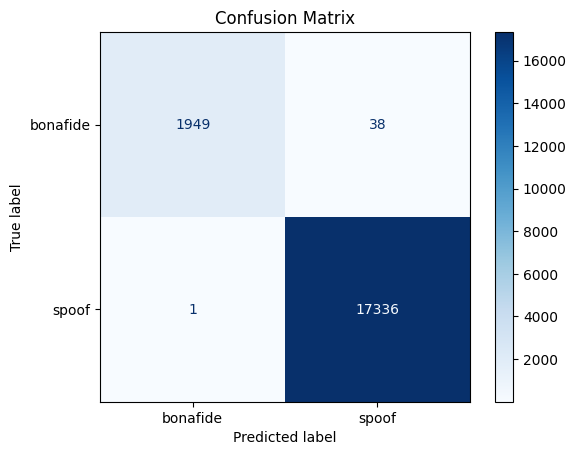

In [ ]:
# Step 6. 학습된 모델 평가

all_preds, all_labels = [], []

model = DeepVoiceDetector().to(device)
model.load_state_dict(torch.load(os.path.join(base_path, 'deepvoice_best.pt'), map_location=device))
model.eval()

with torch.no_grad():
    for mel, label in tqdm(test_loader, desc="🧪 Test Evaluation"):
      mel, label = mel.to(device), label.to(device)
      output = model(mel)
      probs = torch.sigmoid(output)
      all_preds.extend(probs.cpu().numpy())
      all_labels.extend(label.cpu().numpy())

# numpy 변환
true_labels = np.array(all_labels)
pred_probs = np.array(all_preds)
pred_binary = (pred_probs > 0.5).astype(int)

# 🧪 0. 샘플이 없을 경우 종료
if len(true_labels) == 0:
    print("❌ 평가할 샘플이 없습니다.")
else:
    # 1. 분포 출력
    print("✅ 고유 예측 라벨:", np.unique(pred_binary, return_counts=True))
    print("✅ 고유 실제 라벨:", np.unique(true_labels, return_counts=True))

    # 2. classification_report 출력 (zero_division=0으로 경고 억제)
    print("\n📋 Classification Report")
    print(classification_report(true_labels, pred_binary,
                                target_names=['bonafide', 'spoof'],
                                labels=[0, 1],
                                zero_division=0))

    # 3. 추가 지표 출력
    try:
        f1 = f1_score(true_labels, pred_binary, zero_division=0)
        roc_auc = roc_auc_score(true_labels, pred_probs)
        print(f"🎯 F1-score: {f1:.4f}")
        print(f"📈 ROC-AUC: {roc_auc:.4f}")

        # 4. Confusion Matrix 출력 및 시각화
        cm = confusion_matrix(true_labels, pred_binary, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bonafide', 'spoof'])

        print("\n📊 Confusion Matrix:")
        print(cm)

        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()

    except ValueError as e:
        print(f"❗ ROC-AUC 계산 실패: {e}")
